In [1]:
#Model Data Loading

#read features and label data from csv file
import pandas as pd
train_features_final_df = pd.DataFrame(pd.read_csv("train_features_final.csv")).drop('Unnamed: 0', axis=1)
train_targets_final_df = pd.DataFrame(pd.read_csv("train_targets_final.csv")).drop('Unnamed: 0', axis=1)

#Split training dataset into training subset and testing subset
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid= train_test_split(train_features_final_df,train_targets_final_df,test_size=0.3,random_state=0)

In [2]:
#Model Building & Compling
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.utils.vis_utils import plot_model

DogCat_model = Sequential()
DogCat_model.add(BatchNormalization(input_shape=X_train.shape[1:]))
DogCat_model.add(Dense(2))
DogCat_model.add(Activation('softmax'))
DogCat_model.summary()

DogCat_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
plot_model(DogCat_model,to_file='model_v0.png', show_shapes=True, show_layer_names=True)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 4032)              16128     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8066      
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 24,194
Trainable params: 16,130
Non-trainable params: 8,064
_________________________________________________________________


In [18]:
#Model Training

from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='model.v0.weights.best.hdf5', 
                               verbose=1, save_best_only=True)

from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

history=DogCat_model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=100, batch_size=X_train.shape[0], callbacks=[checkpointer,earlystopping], verbose=1)

Train on 17423 samples, validate on 7467 samples
Epoch 1/100
17423/17423 [==============================] - 2s 118us/step - loss: 0.9328 - acc: 0.5414 - val_loss: 0.0472 - val_acc: 0.9862

Epoch 00001: val_loss improved from inf to 0.04719, saving model to model.v0.weights.best.hdf5
Epoch 2/100
17423/17423 [==============================] - 2s 97us/step - loss: 0.0407 - acc: 0.9875 - val_loss: 0.0370 - val_acc: 0.9900

Epoch 00002: val_loss improved from 0.04719 to 0.03704, saving model to model.v0.weights.best.hdf5
Epoch 3/100
17423/17423 [==============================] - 2s 96us/step - loss: 0.0317 - acc: 0.9923 - val_loss: 0.0327 - val_acc: 0.9912

Epoch 00003: val_loss improved from 0.03704 to 0.03272, saving model to model.v0.weights.best.hdf5
Epoch 4/100
17423/17423 [==============================] - 2s 96us/step - loss: 0.0277 - acc: 0.9935 - val_loss: 0.0296 - val_acc: 0.9917

Epoch 00004: val_loss improved from 0.03272 to 0.02955, saving model to model.v0.weights.best.hdf5
Ep


Epoch 00035: val_loss improved from 0.01093 to 0.01081, saving model to model.v0.weights.best.hdf5
Epoch 36/100
17423/17423 [==============================] - 2s 96us/step - loss: 0.0051 - acc: 0.9989 - val_loss: 0.0107 - val_acc: 0.9968

Epoch 00036: val_loss improved from 0.01081 to 0.01071, saving model to model.v0.weights.best.hdf5
Epoch 37/100
17423/17423 [==============================] - 2s 96us/step - loss: 0.0048 - acc: 0.9989 - val_loss: 0.0106 - val_acc: 0.9969

Epoch 00037: val_loss improved from 0.01071 to 0.01062, saving model to model.v0.weights.best.hdf5
Epoch 38/100
17423/17423 [==============================] - 2s 96us/step - loss: 0.0046 - acc: 0.9990 - val_loss: 0.0105 - val_acc: 0.9969

Epoch 00038: val_loss improved from 0.01062 to 0.01053, saving model to model.v0.weights.best.hdf5
Epoch 39/100
17423/17423 [==============================] - 2s 96us/step - loss: 0.0045 - acc: 0.9990 - val_loss: 0.0104 - val_acc: 0.9969

Epoch 00039: val_loss improved from 0.01053

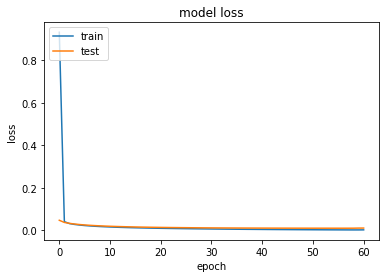

In [19]:
#check loss trend lines

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [3]:
#Loading the best model
DogCat_model.load_weights('model.v0.weights.best.hdf5')

#read features data from csv file
import pandas as pd
test_features_df = pd.DataFrame(pd.read_csv("test_features.csv")).drop('Unnamed: 0', axis=1)

#generate predictions using features
predicted_vector = DogCat_model.predict(test_features_df)

In [21]:
#try on test files
#move all files to a directory names 'unlabeled'
from sklearn.datasets import load_files     
data = load_files('test')
import numpy as np
from keras.utils import np_utils
test_files = np.array(data['filenames'])

#store prediction list into csv files
kaggle_submission=[]
for test_file,prediction in zip(test_files,predicted_vector):
    kaggle_submission.append([test_file.replace('test/unlabeled/','').replace('.jpg',''),prediction[1]])

import pandas as pd
kaggle_submission_df=pd.DataFrame(kaggle_submission, columns=['id','label'])
kaggle_submission_df.to_csv('submission_v0.csv', index=False)

#kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submission_v0.csv -m "model v0" 

In [4]:
#function to reduce absolute prediction
def predict_adjust(x):
    epsilon=0.005
    if x>1-epsilon:
        return 1-epsilon
    if x<epsilon:
        return epsilon
    return x

#try on test files
#move all files to a directory names 'unlabeled'
from sklearn.datasets import load_files     
data = load_files('test')
import numpy as np
from keras.utils import np_utils
test_files = np.array(data['filenames'])

#store prediction list into csv files, using adjusted prediction
kaggle_submission=[]
for test_file,prediction in zip(test_files,predicted_vector):
    kaggle_submission.append([test_file.replace('test/unlabeled/','').replace('.jpg',''),predict_adjust(prediction[1])])

import pandas as pd
kaggle_submission_df=pd.DataFrame(kaggle_submission, columns=['id','label'])
kaggle_submission_df.to_csv('submission_v1.csv', index=False)

#kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f submission_v1.csv -m "model v1"